In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [3]:
data = pd.read_csv('ds_job.csv')

In [4]:
data.head()

,empleado_id,ciudad,indice_desarrollo_ciudad,genero,experiencia_relevante,universidad_matriculado,nivel_educacion,educacion,experiencia,tamano_compania,tipo_compania,ultimo_nuevo_trabajo,horas_formacion,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   empleado_id               19158 non-null  int64  
 1   ciudad                    19158 non-null  object 
 2   indice_desarrollo_ciudad  19158 non-null  float64
 3   genero                    14650 non-null  object 
 4   experiencia_relevante     19158 non-null  object 
 5   universidad_matriculado   18772 non-null  object 
 6   nivel_educacion           18698 non-null  object 
 7   educacion                 16345 non-null  object 
 8   experiencia               19093 non-null  object 
 9   tamano_compania           13220 non-null  object 
 10  tipo_compania             13018 non-null  object 
 11  ultimo_nuevo_trabajo      18735 non-null  object 
 12  horas_formacion           19158 non-null  int64  
 13  target                    19158 non-null  float64
dtypes: flo

In [6]:
data.describe()

,empleado_id,indice_desarrollo_ciudad,horas_formacion,target
count,19158.000000,19158.000000,19158.000000,19158.000000
mean,16875.358179,0.828848,65.366896,0.249348
std,9616.292592,0.123362,60.058462,0.432647
min,1.000000,0.448000,1.000000,0.000000
25%,8554.250000,0.740000,23.000000,0.000000
50%,16982.500000,0.903000,47.000000,0.000000
75%,25169.750000,0.920000,88.000000,0.000000
max,33380.000000,0.949000,336.000000,1.000000


En total vemos que tenemos un dataset con 19158 entradas y 14 columnas o features. De ellas, únicamente 2 son variables numéricas (el id de empleado no se empleará en la modelización, ya que no aporta ninguna información, y la variable target es de tipo numérico pero realmente se puede considerar categórica), siendo todas las demás categóricas. Habrá que hacer por tanto un buen esfuerzo en estudiar y transformar correctamente todas estas variables categóricas.

## 1. Distribución de las variables

array([[<AxesSubplot:title={'center':'empleado_id'}>,
        <AxesSubplot:title={'center':'indice_desarrollo_ciudad'}>],
       [<AxesSubplot:title={'center':'horas_formacion'}>,
        <AxesSubplot:title={'center':'target'}>]], dtype=object)

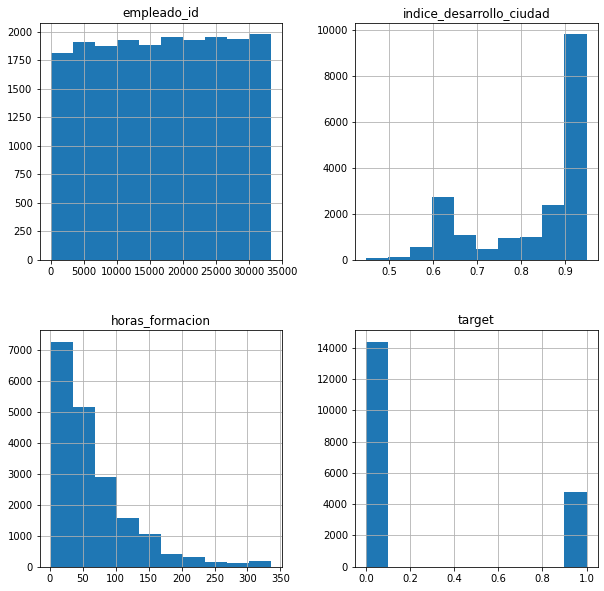

In [7]:
data.hist(figsize=(10,10))

En la distribución de la variable *target* vemos que el dataset está ciertamente desbalanceado (aproximadamente 75%/25%), lo que puede disminuir la eficacia del modelo

In [8]:
cols = [i for i in data if data[str(i)].dtype == 'O']
print(cols)

['ciudad', 'genero', 'experiencia_relevante', 'universidad_matriculado', 'nivel_educacion', 'educacion', 'experiencia', 'tamano_compania', 'tipo_compania', 'ultimo_nuevo_trabajo']


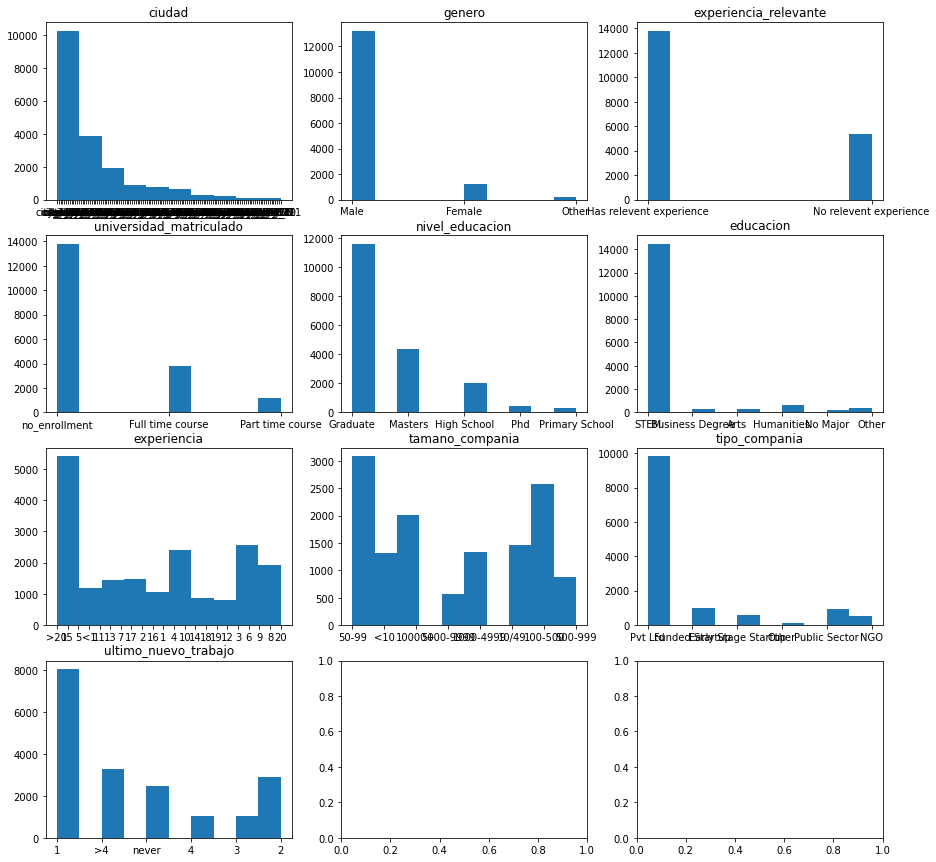

In [9]:
nrows=4
ncols=3
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=False, sharey=False, figsize=(15,15))
for i in range(4):
    for j in range(3):
        idx = (nrows-1)*i+j
        if idx < len(cols):
            ax[i, j].hist(data[cols[idx]].dropna())
            ax[i, j].set_title(cols[idx])
plt.show()

Algunas conclusiones que se pueden obtener de las distribuciones de las variables son:

- La variable género muestra que hay muchas menos mujeres que hombres en puestos de Data Science (sólo en torno al 10%). Esto es incluso poco inferior a los que dice "revistadyna", que menciona que sólo un 15-20% de los puestos de DS están ocupados por mujeres. En dicha variable hay 4508 valores nulos. Podría ser que las mujeres sean más reactivas a dar información sobre su género que los hombres, y por tanto el porcentaje aquí mostrado sea incluso menor que el real. 
- La variable *educacion* es mayoritariamente STEM, lo cual tiene mucho sentido. De hecho, podría ocurrir que si agrupásemos todas las demás carreras en un mismo segmento llamado *otros*, fuese beneficioso para el modelo, ya que ahora mismo cuenta con bastantes segmentos con muy poca relevancia en número frente al segmento mayoritario (STEM). No obstante, no parece que la variable vaya a ser muy importante en el modelo ya que casi todos los trabajadores pertenecen al mismo segmento.
- La variable *experiencia* podría reorganizarse en segmentos más agrupados. De este modo, podríamos diferenciar entre, por ejemplo, experiencia <1, <5, <10, <20 y >20.
- Quizá el tamaño de compañía también podría agruparse más, en pequeña, mediana y gran empresa.
- El tipo de compañía podría poder agruparse en *Pvt Ltd* y *Otros*, aunque habría que verlo más en detalle.

## 2. Correlación entre las variables

Vamos a ver ahora cuál es la correlación entre las distintas variables, en especial con la variable objetivo. Como casi todas las variables son categóricas, este paso no es tan trivial como calcular una matriz de correlación de Pearson, y se ha hecho uso del método empleado en https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9, entrada en la que se indica como calcular las matrices de Cramer y Theil para medir la correlación entre variables, aunque sean categóricas, mostrando el nivel de correlación en el rango [0,1].

In [10]:
import scipy.stats as ss
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [11]:
data1 = data.drop(columns=['empleado_id'])
n = data1.shape[1]
corr_matrix = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        corr_matrix[i, j] = cramers_v(data[data1.columns[i]], data[data1.columns[j]])

In [12]:
df = pd.DataFrame(corr_matrix, columns=data1.columns)

<AxesSubplot:>

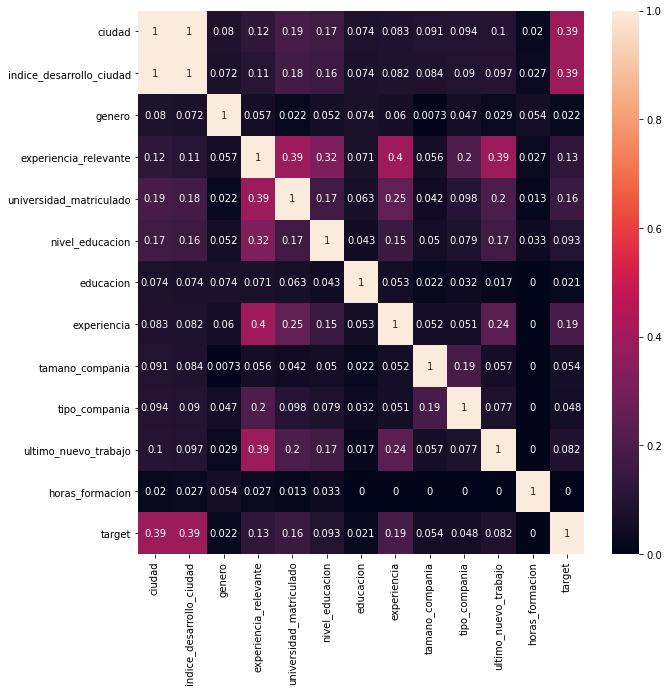

In [13]:
import seaborn as sns
plt.figure(figsize=(10,10))
sns.heatmap(df, vmin=0, vmax=1, annot=True, yticklabels=data1.columns, xticklabels=data1.columns)

La correlación de Cramer mide el nivel de dependencia que existe entre dos variables.

Observamos que las variables *ciudad* y *indice_desarrollo_ciudad* dependen perfectamente una de la otra. Esto tiene setido ya que una misma ciudad siempre va a tener el mismo id. Esto nos permitirá eliminar directamente la variable *ciudad* del dataset, ya que no nos proporcionará más información que la otra. Además, *indice_desarrollo_ciudad* ofrece una información que puede ser valiosa, como es el nivel de desarrollo de la ciudad, y por eso nos quedaremos con esta. Además, esta variable es la que más correlada (0.39) está con la variable *target*, por lo que presumiblemente será muy importante en el proceso de modelado. 

Las variables *experiencia_relevante*, *universidad_matriculado*, y *experiencia* son las tres siguientes de las que más depende la variable objetivo. 

Hay otras variables que están correlacionadas entre sí, como *experiencia* y *experiencia_relevante*, pero el grado de correlación no es tan elevado como para pensar en eliminar una de las dos variables.

Se podría intentar combinar alguna de las variables para ver si se obtienen correlaciones mayores con la variable objetivo, como por ejemplo la experiencia y la experiencia relevante, que además están bastante correlacionadas entre sí; o se podría estudiar si la experiencia en conjunto con estar matriculado en la universidad aumenta la probabilidad de querer cambiar de trabajo. Esto podría ser, ya que una de las razones de inscribirte en la universidad mientras estás trabajando puede ser para buscar mejores oportunidades.

-----------------------------------------------------------------------------------
La matriz de correlación de Cramer es simétrica. Esto implica que si la variable *a* está correlacionada con *b*, *b* lo estará en el mismo grado con *a*. En la misma entrada de blog se propone un método alternativo para estudiar la corelación de forma asimétrica: la matriz de correlación de Theils

In [14]:
from collections import Counter
import math

def conditional_entropy(x, y):
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x, y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0.0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y / p_xy, math.e)
    return entropy

def theils_u(x, y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

In [15]:
theils_u(data['ciudad'], data['target'])

0.022233765571774908

In [16]:
cramers_v(data['ciudad'], data['target'])

0.3875153288684825

In [17]:
theils_u(data['target'], data['ciudad'])

0.13094323321508022

<AxesSubplot:>

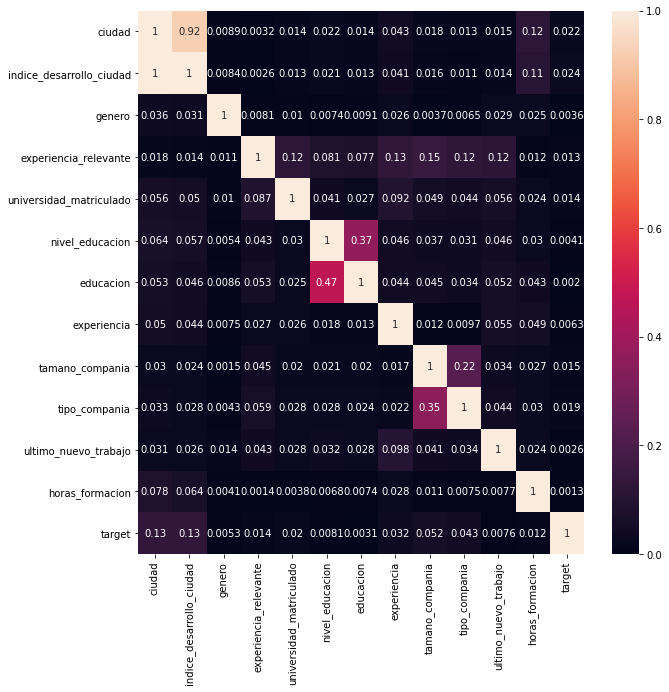

In [18]:
data1 = data.drop(columns=['empleado_id'])
n = data1.shape[1]
corr_matrix1 = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        corr_matrix1[i, j] = theils_u(data[data1.columns[i]], data[data1.columns[j]])
        
df1 = pd.DataFrame(corr_matrix1, columns=data1.columns)
plt.figure(figsize=(10,10))
sns.heatmap(df1, vmin=0, vmax=1, annot=True, yticklabels=data1.columns, xticklabels=data1.columns)

Ahora vemos que, el hecho de que la variable *ciudad* influya sobre el resultado de *target* (0.13), no implica que el valor de *target* explique del mismo modo el valor de *ciudad*. Sin embargo, esta matriz muestra correlaciones mucho más bajas y sobre todo, no hay tanta diferencia entre la dependencia del resto de variables con la variable objetivo, por lo que de momento emplearemos la matriz de Cramer para tomar decisiones.

In [19]:
def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/denominator)
    return eta

In [20]:
correlation_ratio(data['ciudad'], data['indice_desarrollo_ciudad'])

1.0000000000000002

In [21]:
correlation_ratio(data['target'], data['indice_desarrollo_ciudad'])

0.3416650855452297

In [22]:
correlation_ratio(data['target'], data['horas_formacion'])

0.021577249713613234

-------------------------------------------------------------------------------------------------------------------------------------------------------
En las dos matrices anteriores vemos que la correlación entre las dos variables numéricas es prácticamente inexistente. Para asegurarnos, vamos a comprobar la correlación de Pearson entre estas dos variables:

In [23]:
data[['indice_desarrollo_ciudad', 'horas_formacion']].corr()

,indice_desarrollo_ciudad,horas_formacion
indice_desarrollo_ciudad,1.00000,0.00192
horas_formacion,0.00192,1.00000


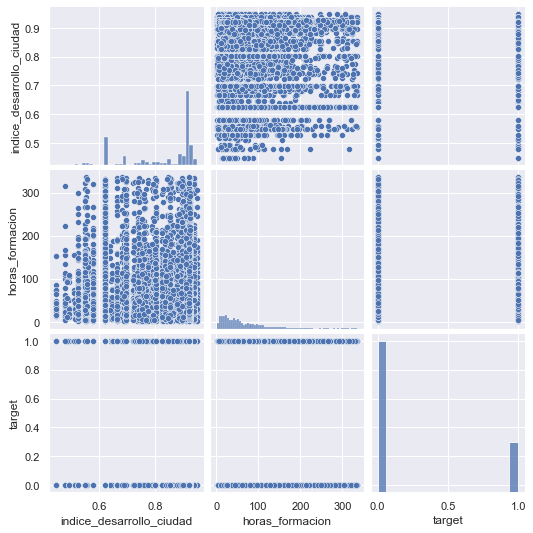

In [110]:
sns.pairplot(data[['indice_desarrollo_ciudad', 'horas_formacion', 'target']])

Vemos que efectivamente no existe correlación entre ellas.

## 3. Análisis con la variable target

Ahora que hemos visto como se correlacionan las variables entre sí, vamos a ver como se comportan algunas de ellas con la variable target:


In [25]:
test = data[['indice_desarrollo_ciudad', 'target']]

In [26]:
def id_ciudad(x):
    if x<0.5:
        return '<0.5'
    elif x<0.6:
        return '<0.6'
    elif x<0.7:
        return '<0.7'
    elif x<0.8:
        return '<0.8'
    elif x<0.9:
        return '<0.9'
    else:
        return '<1'

In [27]:
test['idx'] = test.indice_desarrollo_ciudad.apply(id_ciudad)

<ipython-input-27-ee2c30e8eb5f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['idx'] = test.indice_desarrollo_ciudad.apply(id_ciudad)


In [28]:
test = test.drop(columns='indice_desarrollo_ciudad')

In [97]:

def plot_info(df, column, vals=None):
    if vals is None:
        vals = np.unique(df[column])

    t = np.zeros((2, len(vals)))
    for i, value in enumerate(vals):
        t[0, i] = df[(df[column] == value) & (df['target'] == 0.0)].value_counts()
        t[1, i] = df[(df[column] == value) & (df['target'] == 1.0)].value_counts()
        t[0,i] /= df[df[column] == value].value_counts().sum()
        t[1,i] /= df[df[column] == value].value_counts().sum()


    df1 = pd.DataFrame(t.T, index=vals)
    plt.figure()
    df1.plot.bar(stacked=True)
    plt.title('Target por ' + column)
    plt.show()

<Figure size 432x288 with 0 Axes>

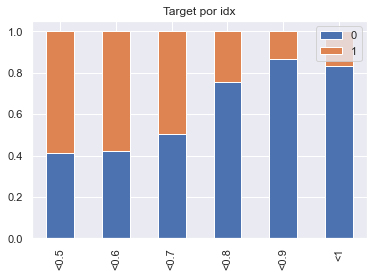

In [106]:
plot_info(test, 'idx')

Vemos en el gráfico de arriba como cuanto mayor es el índice de desarrollo de la ciudad, menos probabilidades hay de cambiar de trabajo. Es decir, más del 80% de los empleados en ciudades con un id de desarrollo superior a 0.8 no busca cambiar de trabajo. Por el contrario, en ciudades menos desarrolladas ocurre lo contrario, donde el porcentaje de empleados que sí quiere cambiar de trabajo asciende a casi el 60%. Vemos por tanto una clara tendencia que puede ser muy explicativa de la variable *target*.

In [107]:
test1 = data[['target', 'tamano_compania']]
test1['tamano_compania'] = test1.tamano_compania.apply(lambda x: str(x))

<Figure size 432x288 with 0 Axes>

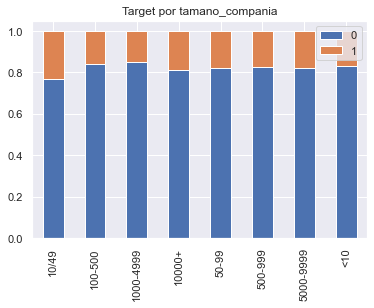

In [108]:
plot_info(test1[test1['tamano_compania'] != 'nan'], 'tamano_compania')

Vemos que el querer cambiar o no de trabajo es independiente del tamaño de la empresa, ya que el ratio está siempre en torno al 80%

<Figure size 432x288 with 0 Axes>

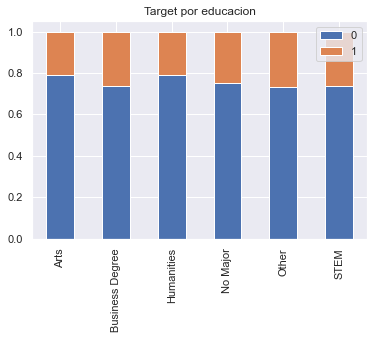

In [109]:
test1 = data[['target', 'educacion']]
test1['educacion'] = test1.educacion.apply(lambda x: str(x))
plot_info(test1[test1['educacion'] != 'nan'], 'educacion')

<Figure size 432x288 with 0 Axes>

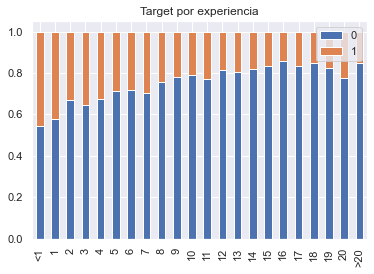

In [100]:
col = 'experiencia'
test1 = data[['target', col]]
vals = ['<1'] + list(range(1,21)) + ['>20']
vals = [str(i) for i in vals]
test1[col] = test1[col].apply(lambda x: str(x))
plot_info(test1[test1[col] != 'nan'], col, vals=vals)

También se aprecia aqui una tendencia: cuantos más años de experiencia, menor es la probabilidad de querer cambiar de trabajo

<Figure size 432x288 with 0 Axes>

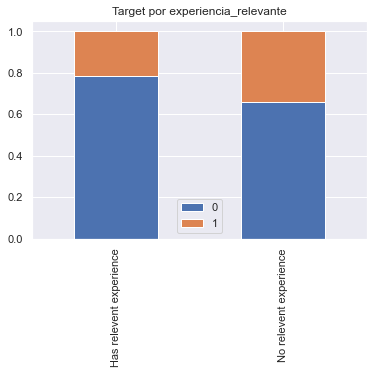

In [101]:
col = 'experiencia_relevante'
test1 = data[['target', col]]
test1[col] = test1[col].apply(lambda x: str(x))
plot_info(test1[test1[col] != 'nan'], col)

<Figure size 432x288 with 0 Axes>

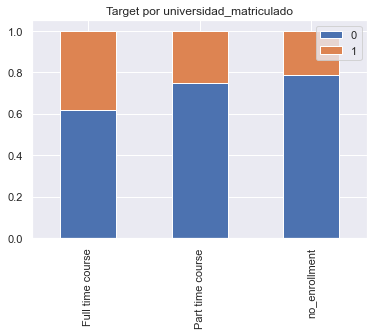

In [102]:
col = 'universidad_matriculado'
test1 = data[['target', col]]
test1[col] = test1[col].apply(lambda x: str(x))
plot_info(test1[test1[col] != 'nan'], col)

Si estás matriculado en la universidad mientras trabajas, es probable que sea con la intención de adquirir nuevas capacidades para querer cambiar de sector, ascender, etc.

<Figure size 432x288 with 0 Axes>

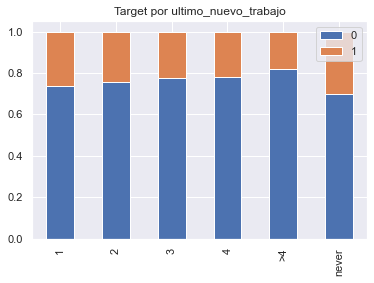

In [103]:
col = 'ultimo_nuevo_trabajo'
test1 = data[['target', col]]
test1[col] = test1[col].apply(lambda x: str(x))
plot_info(test1[test1[col] != 'nan'], col)

Por lo que parece, el haber cambiado de trabajo o no no afecta mucho a querer cambiar de nuevo

<Figure size 432x288 with 0 Axes>

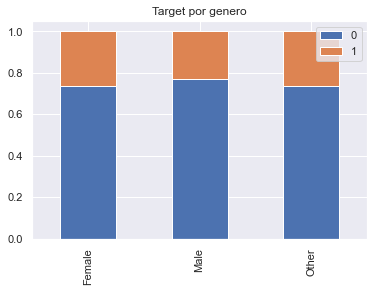

In [104]:
col = 'genero'
test1 = data[['target', col]]
test1[col] = test1[col].apply(lambda x: str(x))
plot_info(test1[test1[col] != 'nan'], col)

<Figure size 432x288 with 0 Axes>

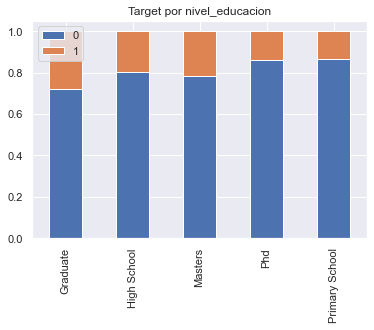

In [105]:
col = 'nivel_educacion'
test1 = data[['target', col]]
test1[col] = test1[col].apply(lambda x: str(x))
plot_info(test1[test1[col] != 'nan'], col)

Tampoco se observa una relación clara entre el nivel de educación y la variable objetivo